<div align="center"><b> APSERa Simulation for 2-4 GHz </b></div>


<div align="center"><b> Importing required packages </b></div>


In [1]:
#The following code is written using GlobalSkyModel and not GlobalSkyModel2016. The difference is just the units, and that can be modified anytime.

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import ephem

%matplotlib inline

from pygsm import GlobalSkyModel
from ms_fit_joint import ms_fit, chisq_poly
import maxsmooth
from maxsmooth.DCF import smooth

from astropy.time import Time
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u

import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline



<div align="center"><b> Definitions </b></div>


In [2]:
h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08
TCMB = 2.72548
f_start = 2
f_stop = 4
No_of_Channels = 201
Channel_width = 0.01
N_SIDE = 16
T_hot = 3730
T_cold = 2730         #T_cold and T_hot in Kelvins
Time_in_UTC = '2012-05-20 1:45:00'  
latitude = 13.067439
longitude = 80.237617       #Latitude and longitude in degrees
altitude = 0            #Altitude in meters
alpha = 0.0065            #Temp. lapse rate (deg C per meter)
PI = 3.14159265
Noise_int_time = 2.7e10
Trx = 14
T_atm = 1
freqs = np.linspace(f_start,f_stop, No_of_Channels)
CMB_Int = np.empty([No_of_Channels])
P_hot = np.empty(No_of_Channels)
P_cold = np.empty(No_of_Channels)
P_dif = np.empty(No_of_Channels)
cross_real = [0]*No_of_Channels
cross_imag = [0]*No_of_Channels
sumwt = [0]*No_of_Channels
sigma = [0]*No_of_Channels

cross_real1 = [0]*No_of_Channels
cross_imag1 = [0]*No_of_Channels
sumwt1 = [0]*No_of_Channels
sigma1 = [0]*No_of_Channels

#Refraction correction formula
def refraction(alt_in_deg, altitude):
    pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)
    if (altitude>11000):
        temp = 211.5
    else:
        temp = 283.0 - (alpha * altitude)
    R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))
    if (alt_in_deg == 90):
        R = R+ 0.0019279
    tpcor = (pres/1000) * (283/temp)
    R =  tpcor*(R/60)
    return alt_in_deg +R

#Beam definition
def beam_def(freq, az, alt):
    if (alt<=0):
        return 0
    else:
        return (math.sin(alt*PI/180)*math.sin(alt*PI/180))
    

<div align="center"><b> Getting maps, calculating CMB intensity </b></div>


In [3]:
freq_split = (np.array_split(freqs, 6))
gsm = GlobalSkyModel(freq_unit='GHz')

#The gsm values can be extracted in a single line of code. I broke into 6 lines and joined again, as my system can't handle! 

spectrum1 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[0]))), N_SIDE)
spectrum2 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[1]))), N_SIDE)
spectrum3 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[2]))), N_SIDE)
spectrum4 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[3]))), N_SIDE)
spectrum5 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[4]))), N_SIDE)
spectrum6 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[5]))), N_SIDE)


map_1 = (np.concatenate((spectrum1, spectrum2, spectrum3, spectrum4,spectrum5, spectrum6), axis=0))

#The map is in antennae Temp units. The below line is to convert it into same power units 
map_1 = 2*k*map_1         # = 2kT (Still a bit confused if this is correct)


CMB_Int = ((2*h*1e+27*freqs**3)/(c*c))/(np.exp((h*freqs*1e+9)/(k*TCMB))-1)
CMB_Int_RJ = CMB_Int * c*c/ (1e+18* freqs**2)

#P_hot and P_cold for calibration
P_hot = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_hot))-1)
P_cold = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_cold))-1)
P_dif = P_hot -P_cold



<div align="center"><b> Getting recombination lines </b></div>


In [4]:
NPIX = hp.nside2npix(N_SIDE)
df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]

x = df["Frequency"]
y= df["Intensity"]

ius = InterpolatedUnivariateSpline(x, y)
Rec_int = ius(freqs)

#Converting into same power units as CMB and rec line 
Rec_int = Rec_int *  c*c/ (1e+18* freqs**2)


/tmp/ipykernel_23577/3424313489.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)


<div align="center"><b> Getting temperature values after calibration </b></div>


In [5]:
i=1
while i<NPIX:           #Working on each pixel
    coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
    gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
    equi = gc.transform_to(AltAz(obstime = Time_in_UTC, location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m)))
    alt = equi.alt.value
    new_alt = refraction(alt, altitude) 
    
    
    
    j=0
    while j< No_of_Channels:
        cwt = beam_def(freqs[j],equi.az.value, new_alt)
        
        if (cwt>0):     #Adding all 3 intensities
            Power = map_1[j][i-1] + Rec_int[j] + CMB_Int_RJ[j]
            final_temp = (Power/P_dif[j])*(T_hot-T_cold)
            cross_real[j] = cross_real[j] + cwt*final_temp
            sumwt[j] = sumwt[j]+ cwt
            
#Uncomment for checking seperate intensities            
        if (cwt>0):     #Checking for any one intensity alone
            Power = CMB_Int_RJ[j]   # or Power = map_1[j][i-1]  
            final_temp = (Power/P_dif[j])*(T_hot-T_cold)
            cross_real1[j] = cross_real1[j] + cwt*final_temp
            sumwt1[j] = sumwt1[j]+ cwt
            
        j = j+1
        
    
    i = i+1

    
i=0    
while(i< No_of_Channels):
    if sumwt[i]>0:
        cross_real[i] = cross_real[i]/sumwt[i]
    i = i+1

#Uncomment for checking seperate intensities        
i=0    
while(i< No_of_Channels):
    if sumwt1[i]>0:
        cross_real1[i] = cross_real1[i]/sumwt1[i]
    i = i+1


In [6]:
#Adding thermal noise to the final spectrum    
#For the total power radiometer:
sigma = (np.array(cross_real) + Trx+ T_atm)/ math.sqrt(Channel_width*1e6*Noise_int_time)

#Uncomment for checking seperate intensities    
sigma1 = (np.array(cross_real1) + Trx+ T_atm)/ math.sqrt(Channel_width*1e6*Noise_int_time)


#Generating array of random numbers(of length = No.of channels) with mean =0, std = 1 
array = np.random.normal(0,1,No_of_Channels)

cross_real = cross_real + array*sigma
cross_imag = cross_imag + array*sigma

#Uncomment for checking seperate intensities   
cross_real1 = cross_real1 + array*sigma1
cross_imag1 = cross_imag1 + array*sigma1



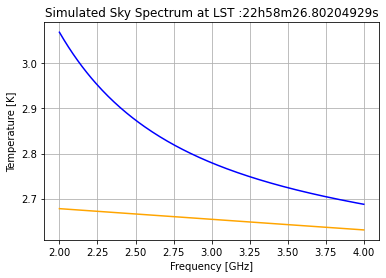

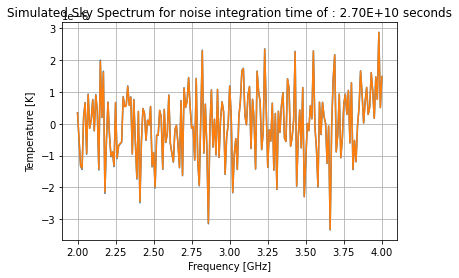

In [7]:
Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
lst = t.sidereal_time('apparent')


plt.plot(freqs, cross_real, color = 'blue')   
plt.plot(freqs, cross_real1, color = 'orange')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s'%lst)
plt.grid()
plt.show()

plt.plot(freqs, cross_imag)
plt.plot(freqs, cross_imag1)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum for noise integration time of : %.2E seconds'%Noise_int_time)
plt.grid()
plt.show()

<div align="center"><b> Fitting with Maxsmooth function </b></div>


##################################################
--------------------OPTIMUM RESULT--------------------
Time: 4.5134594440460205
Polynomial Order: 14
Number of Constrained Derivatives: 12
Signs : [-1  1 -1  1 -1  1 -1  1 -1 -1 -1 -1]
Objective Function Value: 9.233073220275227e-09
Parameters: [[ 2.77948331e+00 -1.39342834e-01  7.39109547e-02 -3.96552479e-02
   1.88173757e-02 -8.87178030e-03  5.07583101e-03 -2.69588507e-03
   8.92764846e-04 -1.51933816e-04  4.08215587e-06  1.10294953e-06
   1.83455263e-07  1.41064595e-08]]
Method: qp-sign_flipping
Model: difference_polynomial
Constraints: m >= 2
Zero Crossings Used? (0 signifies Yes
 in derivative order "i"): {'0': 1, '1': 1}
--------------------------------------------------
##################################################


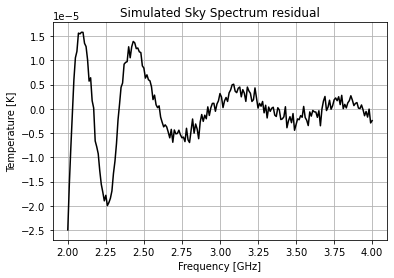

/tmp/ipykernel_23577/1433744247.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)


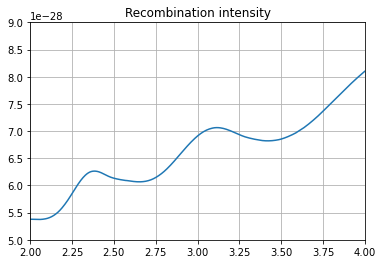

In [10]:

#Using maxsmooth function
result = smooth(freqs, cross_real, 14)
C = result.y_fit

#Uncomment for checking seperate intensities 
# result1 = smooth(freqs, cross_real1, 14)
# D = result1.y_fit

plt.plot(freqs, cross_real- C, color = 'black')
#plt.plot(freqs, cross_real1- D, color = 'blue')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum residual')
plt.grid()
plt.show()

df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]
plt.plot(df['Frequency'], df['Intensity'])
plt.title('Recombination intensity')
plt.xlim([2,4])
plt.ylim([5e-28,9e-28])
plt.grid()
plt.show()

<div align="center"><b> Fitting with MS_fit function </b></div>


+------------------+--------------------+
|    Parameter     |       Value        |
+------------------+--------------------+
|      error       |    201 elements    |
|       xtol       |       1e-06        |
|       ftol       |       1e-06        |
|      domain      |      lin_lin       |
|     maxiter      |      100000.0      |
|      maxfev      |      100000.0      |
|       algo       |    Nelder-Mead     |
|      norder      |         8          |
|       temp       |        0.1         |
|     stepsize     |        0.1         |
|      niter       |         1          |
| basin_iter_loops |         10         |
|       xmin       |        2.0         |
|       xmax       |        4.0         |
|     rescale      |        True        |
|       seed       |         1          |
|     additive     |        True        |
|      joint       |       False        |
|      signal      |      [False]       |
|     add_ini      |        0.0         |
|     op_file      |        True  

/home/dhashin/ms_fit_joint.py:283: UserWarning: 
Leastsq gives different basinhopping. Fit might not have converged, don't trust the errors!

  warnings.warn("\nLeastsq gives different basinhopping. Fit might not have converged, don't trust the errors!\n")


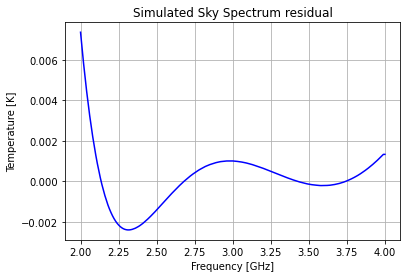

In [11]:

Res = (ms_fit(freqs, cross_real, norder = 8, error = cross_imag))
#Res1 = (ms_fit(freqs, cross_real1, norder = 8, error = cross_imag1))

#Res[5] gives the residual value after fitting. Res[5] array and Res[4] has only 200 values, while input 201 values. Not sure why. For plotting,I just added one term 
Res5 = Res[5]
Res5 = np.append(Res5, Res5[No_of_Channels - 2])

#Res[4] gives the fitting function
Res4 = Res[4]
Res4 = np.append(Res4, Res4[No_of_Channels - 2])

plt.plot(freqs, Res5, color = 'blue')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum residual')
plt.grid()
#plt.ylim([-0.002,0.002])
plt.show()

<div align="center"><b> Fitting with 'custom' MS_fit function </b></div>
